# Modelo DNN

### Se importan librerías necesarias

In [1]:
# !pip install tensorflow==2.15.0

In [2]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# import seaborn as sns
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")
print(tf.__version__)

2024-06-20 16:35:44.419738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 16:35:44.419888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 16:35:44.549838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
def load_workspace():
    #Conexión de google drive con el repo
    # from google.colab import drive
    # drive.mount('/content/drive')

    ###==========================
    # ruta = os.path.join("/content/drive/MyDrive","MonografiaUdeA")
    # os.chdir(ruta)
    abspath = pathlib.Path.cwd()
    print(f"Directorio de trabajo: {abspath}")
    ###==========================
    return abspath
    
abspath = load_workspace()

Directorio de trabajo: /kaggle/working


In [4]:
def parse(x):
    return dt.datetime.strptime(x, '%Y-%m-%d')
# dataset = pd.read_csv(os.path.join(abspath,"datasets", "procesado", "3_dataset_filtrado.csv"), index_col=0, date_parser=parse)
def get_dataset():
    dataset = pd.read_csv("https://raw.githubusercontent.com/cjusquini/MonografiaUdeA/main/datasets/procesado/3_dataset_filtrado.csv", index_col=0, date_parser=parse)
#     df = dataset.copy()    
    return dataset

df = get_dataset()
df.head()

,precio_bolsa,demanda,disp_dec_hidraulica,disp_dec_termica,gen_hidraulica,gen_no_termica,gen_termica,aportes_energia,precio_oferta,vol_util,indice_ONI,vertimientos
fecha,,,,,,,,,,,,
2010-01-01,120.501228,1.133616e+08,356125.000000,121611.607143,35796804.67,13362226.83,66260052.96,45616100.0,267.437633,1.000661e+10,1.5,0.0
2010-01-02,118.495340,1.254718e+08,353776.515152,121633.928571,46595646.99,13393741.63,67691806.16,43097100.0,277.153592,9.995147e+09,1.5,0.0
2010-01-03,121.160145,1.211452e+08,356579.545455,119455.357143,42578875.20,13046074.83,68012828.41,43400400.0,313.552755,9.992677e+09,1.5,0.0
2010-01-04,123.962937,1.439317e+08,341617.424242,116611.607143,62242326.79,13160643.95,70554488.25,40410400.0,303.519878,9.965341e+09,1.5,0.0
2010-01-05,120.666437,1.498691e+08,346125.000000,116613.095238,69173462.65,14514419.15,68460147.29,41190600.0,339.600449,9.926760e+09,1.5,0.0


In [5]:
def scale_df(df):
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    #         scaled_df.head(5)
    
    return scaler, scaled_df
        
scaler, scaled_df = scale_df(df)
scaled_df.head(5)

,precio_bolsa,demanda,disp_dec_hidraulica,disp_dec_termica,gen_hidraulica,gen_no_termica,gen_termica,aportes_energia,precio_oferta,vol_util,indice_ONI,vertimientos
fecha,,,,,,,,,,,,
2010-01-01,0.044641,0.000000,0.654490,0.612788,0.000000,0.755503,0.665266,0.029498,0.144822,0.484812,0.738095,0.0
2010-01-02,0.043589,0.120600,0.645406,0.613112,0.074578,0.757482,0.682814,0.025017,0.162552,0.483498,0.738095,0.0
2010-01-03,0.044986,0.077513,0.656248,0.581456,0.046838,0.735654,0.686748,0.025557,0.228976,0.483215,0.738095,0.0
2010-01-04,0.046456,0.304433,0.598374,0.540133,0.182635,0.742847,0.717898,0.020238,0.210667,0.480082,0.738095,0.0
2010-01-05,0.044727,0.363560,0.615809,0.540155,0.230502,0.827840,0.692230,0.021626,0.276509,0.475660,0.738095,0.0


In [6]:
# scaled_df.tail(5)

### División de datos en entrenamiento y prueba

In [7]:
def create_sequences(data, n_lag, target_column):
    sequences = []
    targets = []
    for i in range(len(data) - n_lag):
        seq = data[i:i + n_lag]
        target = data[i + n_lag][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def split_data(lags, scaled_df, train_test_split_ratio = 0.7):
  lagged_data = {}
  for lag in lags:
      X, y = create_sequences(scaled_df.values, lag, target_column=0)
      lagged_data[lag] = (X, y)

  train_test_split_ratio = train_test_split_ratio
  split_idx = int(len(scaled_df) * train_test_split_ratio)

  train_data = {lag: (X[:split_idx], y[:split_idx]) for lag, (X, y) in lagged_data.items()}
  test_data = {lag: (X[split_idx:], y[split_idx:]) for lag, (X, y) in lagged_data.items()}

  # lagged_data_no_var = {}
  # for lag in retardos:
  #     X, y = create_sequences(scaled_df.drop(columns=['precio_bolsa']).values, lag, target_column=0)
  #     lagged_data_no_var[lag] = (X, y)

  # train_data_no_var = {lag: (X[:split_idx], y[:split_idx]) for lag, (X, y) in lagged_data_no_var.items()}
  # test_data_no_var = {lag: (X[split_idx:], y[split_idx:]) for lag, (X, y) in lagged_data_no_var.items()}

  return train_data, test_data#, train_data_no_var, test_data_no_var

def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, mape, rmse

## Creación de arquitectura de modelos

In [8]:
def create_model(model_type, input_shape, elements_to_predict, optimizer, loss, neuronas = 20):

    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(neuronas, input_shape=input_shape))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(20, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'DNN':
        model.add(Dense(neuronas, input_shape=input_shape))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(20, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'LSTM':
        model.add(LSTM(neuronas, input_shape=input_shape))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(20, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'GRU':
        model.add(GRU(neuronas, input_shape=input_shape))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(20, activation='relu'))
        model.add(Dropout(0.3))

    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss = loss)
    print(f"Model {model_type} created. Params -> input_shape: {input_shape}, elements_to_predict: {elements_to_predict}, optimizer: {optimizer}, loss: {loss}")
    return model

In [9]:
def get_hyperparams():
    retardos = [60]
    neurons = [20, 25, 30]
    modelos_implementar = ['DNN']
    elementos_a_predecir = [30]
    optimizers = ['adam']
    losses = ['mse']
    epochs = [150]
    batch_size = [64, 32]
    
    return retardos, neurons, modelos_implementar, elementos_a_predecir, optimizers, losses, epochs, batch_size

In [10]:
# def get_hyperparams():
#     retardos = [60]
#     neurons = [20]
#     modelos_implementar = ['DNN']
#     elementos_a_predecir = [30]
#     optimizers = ['adam']
#     losses = ['mse']
#     epochs = [150]
#     batch_size = [32]
    
#     return retardos, neurons, modelos_implementar, elementos_a_predecir, optimizers, losses, epochs, batch_size

In [11]:
# for retardo in retardos:
#     print("retardo",retardo, "dimensiones",train_data[retardo][0].shape, test_data[retardo][0].shape)

In [12]:
#Se inicializa la semilla
np.random.seed(42)
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)

In [13]:
# Create arrays to represent parameter combinations
def create_combinations():
    """
    """
    retardos, neurons, modelos_implementar, \
    elementos_a_predecir, optimizers, losses, \
    epochs, batch_size = get_hyperparams()
    
    train_data, test_data = split_data(lags = retardos, scaled_df = scaled_df, train_test_split_ratio = 0.8)
    
    models_with_var = {lag: {} for lag in retardos}
    
    lag_grid, model_grid, optimizer_grid, loss_grid, element_grid, neurons_grid = np.meshgrid(retardos, modelos_implementar, optimizers, losses, elementos_a_predecir, neurons)
    lag_grid = lag_grid.flatten()
    model_grid = model_grid.flatten()
    optimizer_grid = optimizer_grid.flatten()
    loss_grid = loss_grid.flatten()
    element_grid = element_grid.flatten()
    neurons_grid = neurons_grid.flatten()
        
    return models_with_var, train_data, test_data,\
            lag_grid, model_grid, optimizer_grid,\
            loss_grid, element_grid, neurons_grid,\
            epochs, batch_size

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_best_model():
    """
    """
    early_stopping = EarlyStopping(monitor='loss', patience = 15, mode = 'min', start_from_epoch = 30)
    model_summary_df = pd.DataFrame()
    index = 0
    best_score = float("inf")
    best_model = []
    
    models_with_var, train_data, test_data,\
        lag_grid, model_grid, optimizer_grid,\
        loss_grid, element_grid, neurons_grid,\
        epochs, batch_size = create_combinations()
    
    for model, lag, element_to_predict, optimizer, loss, neurons  in zip(model_grid, lag_grid, element_grid, optimizer_grid, loss_grid, neurons_grid):
        if not os.path.exists(os.path.join(abspath,"models","iterations",model)):
                os.makedirs(os.path.join(abspath,"models","iterations",model))
        input_shape = train_data[lag][0].shape[1:]
        models_with_var[lag][model] = create_model(model, input_shape, elements_to_predict=element_to_predict, optimizer=optimizer, loss=loss, neuronas= neurons)
        for epoch in epochs:
            for batch in batch_size:
                print(f"modelo: {model}, neuronas: {neurons},lag: {lag}, elementos: {element_to_predict}, optimizador: {optimizer}, perdida: {loss}, epoch: {epoch}, batch: {batch}")
                _model = models_with_var[lag][model]
                X_train, y_train = train_data[lag]
                X_test, y_test = test_data[lag]
                tf.keras.backend.clear_session()
                history = _model.fit(
                    X_train, y_train,
                    epochs=epoch, batch_size=batch,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=0
                )
                y_pred = _model.predict(X_test)
                X_train_rescaled = scaler.inverse_transform(np.hstack((X_train[:, -1, 0].reshape(-1,1),X_train[:, -1, 1:])))[:,0]
                y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred,X_test[:, -1, 1:])))[:,0]
                y_test_rescaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1,1),X_test[:, -1, 1:])))[:,0]


                mae, mse, mape, rmse = get_metrics(y_test_rescaled[:int(element_to_predict)], y_pred_rescaled[:int(element_to_predict)])
    #             mse = mean_squared_error(y_test_rescaled[-int(element_to_predict):], y_pred_rescaled[-int(element_to_predict):])
    #             mae = mean_absolute_error(y_test_rescaled[-int(element_to_predict):], y_pred_rescaled[-int(element_to_predict):])
    #             rmse = mean_squared_error(y_test_rescaled[-int(element_to_predict):], y_pred_rescaled[-int(element_to_predict):], squared=False)
    #             mape = mean_absolute_percentage_error(y_test_rescaled[-int(element_to_predict):], y_pred_rescaled[-int(element_to_predict):])
                
                model_summary_df = pd.concat([model_summary_df, pd.DataFrame( {
                    'id': index,
                    'Modelo': model,
                    'Neuronas': neurons,
                    'LookBack': lag,
                    'Elementos': element_to_predict,
                    'Optimizador': optimizer,
                    'Epocas': epoch,
                    'BatchSize': batch,
                    'MAE [$COP/kWh]': mae,
                    'MSE [$COP/kWh]': mse,
                    'RMSE [$COP/kWh]': rmse,
                    'MAPE [%]': mape,
                }, index = [index])] )
                
                if mse < best_score:
                    best_score, best_model, best_index = mse, _model, index
                    
                index = index + 1
                        
    model_path = os.path.join(abspath,"models","iterations",model, f'{model}_{best_index}.keras')
    if os.path.exists(model_path):
        os.remove(model_path)
    _model.save(os.path.join(model_path))
    print(f"model: {model_path} saved")
    #             del _model
    return _model, model_summary_df, best_index, history

best_model, model_summary_df, best_index, best_model_history = get_best_model()

Model DNN created. Params -> input_shape: (60, 12), elements_to_predict: 30, optimizer: adam, loss: mse
modelo: DNN, neuronas: 20,lag: 60, elementos: 30, optimizador: adam, perdida: mse, epoch: 150, batch: 64


I0000 00:00:1718901361.155938     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718901361.170212     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718901364.145254     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718901364.503861     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
modelo: DNN, neuronas: 20,lag: 60, elementos: 30, optimizador: adam, perdida: mse, epoch: 150, batch: 32


W0000 00:00:1718901372.269240     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model DNN created. Params -> input_shape: (60, 12), elements_to_predict: 30, optimizer: adam, loss: mse
modelo: DNN, neuronas: 25,lag: 60, elementos: 30, optimizador: adam, perdida: mse, epoch: 150, batch: 64


W0000 00:00:1718901385.817967     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
modelo: DNN, neuronas: 25,lag: 60, elementos: 30, optimizador: adam, perdida: mse, epoch: 150, batch: 32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model DNN created. Params -> input_shape: (60, 12), elements_to_predict: 30, optimizer: adam, loss: mse
modelo: DNN, neuronas: 30,lag: 60, elementos: 30, optimizador: adam, perdida: mse, epoch: 150, batch: 64


W0000 00:00:1718901407.851925     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718901411.047616     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
modelo: DNN, neuronas: 30,lag: 60, elementos: 30, optimizador: adam, perdida: mse, epoch: 150, batch: 32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
model: /kaggle/working/models/iterations/DNN/DNN_2.keras saved


In [15]:
retardos, neurons, modelos_implementar, \
    elementos_a_predecir, optimizers, losses, \
    epochs, batch_size = get_hyperparams()

train_data, test_data = split_data(lags = retardos, scaled_df = scaled_df, train_test_split_ratio = 0.8)

if not os.path.exists(os.path.join(abspath,"models", "results")):
        os.makedirs(os.path.join(abspath,"models", "results"))
model_summary_df.to_excel(os.path.join(abspath,"models", "results",f"{modelos_implementar[0]}_model_results.xlsx"))
model_summary_df.head()

,id,Modelo,Neuronas,LookBack,Elementos,Optimizador,Epocas,BatchSize,MAE [$COP/kWh],MSE [$COP/kWh],RMSE [$COP/kWh],MAPE [%]
0,0,DNN,20,60,30,adam,150,64,19.630996,520.769082,22.820366,10.977532
1,1,DNN,20,60,30,adam,150,32,18.026454,421.825238,20.538384,10.627232
2,2,DNN,25,60,30,adam,150,64,15.882383,389.880077,19.745381,9.367912
3,3,DNN,25,60,30,adam,150,32,18.010284,436.553718,20.893868,10.258877
4,4,DNN,30,60,30,adam,150,64,16.141639,396.455623,19.911193,9.362339


In [16]:
best_model = model_summary_df[model_summary_df['MSE [$COP/kWh]'] == model_summary_df['MSE [$COP/kWh]'].min()]
best_model

,id,Modelo,Neuronas,LookBack,Elementos,Optimizador,Epocas,BatchSize,MAE [$COP/kWh],MSE [$COP/kWh],RMSE [$COP/kWh],MAPE [%]
2,2,DNN,25,60,30,adam,150,64,15.882383,389.880077,19.745381,9.367912


### Se carga el mejor modelo

In [17]:
best_model_saved =load_model(os.path.join(abspath,"models","iterations",f'{modelos_implementar[0]}', f'{modelos_implementar[0]}_{best_index}.keras'))
best_model_saved.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60, 30)         │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        36,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,295 (426.94 KB)

 Trainable params: 36,431 (142.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72,864 (284.63 KB)

In [18]:
X_train, y_train = train_data[best_model["LookBack"].values[0]]
X_test, y_test = test_data[best_model["LookBack"].values[0]]

### Predicciones con el mejor modelo

In [19]:
 y_pred = best_model_saved.predict(X_test)
X_train_rescaled = scaler.inverse_transform(np.hstack((X_train[:, -1, 0].reshape(-1,1),X_train[:, -1, 1:])))[:,0]
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred,X_test[:, -1, 1:])))[:,0]
y_test_rescaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1,1),X_test[:, -1, 1:])))[:,0]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [20]:
fechas = [str(x)[:10] for x in scaled_df.index]

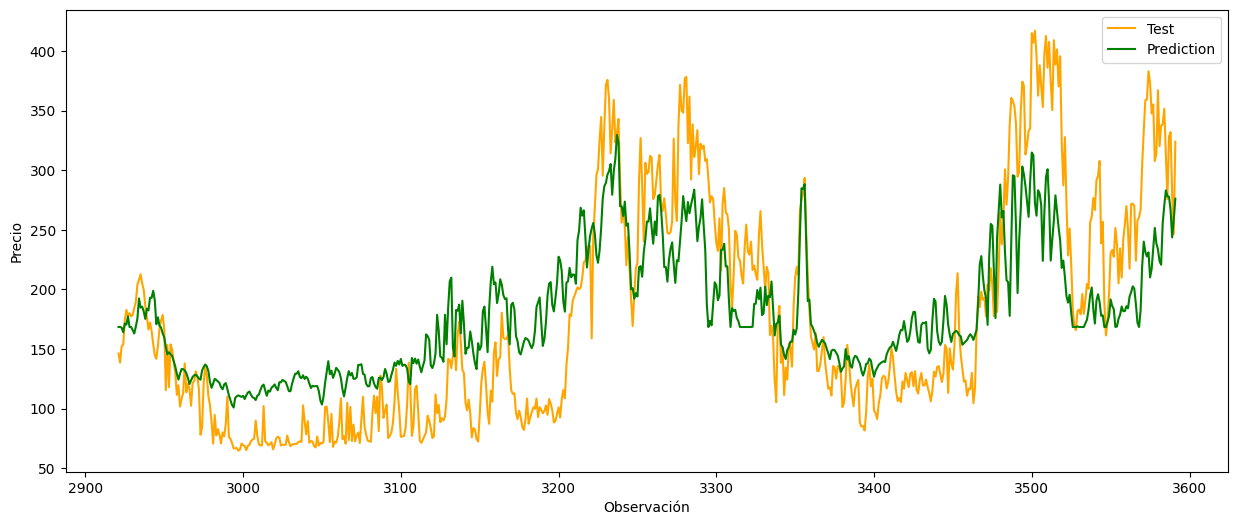

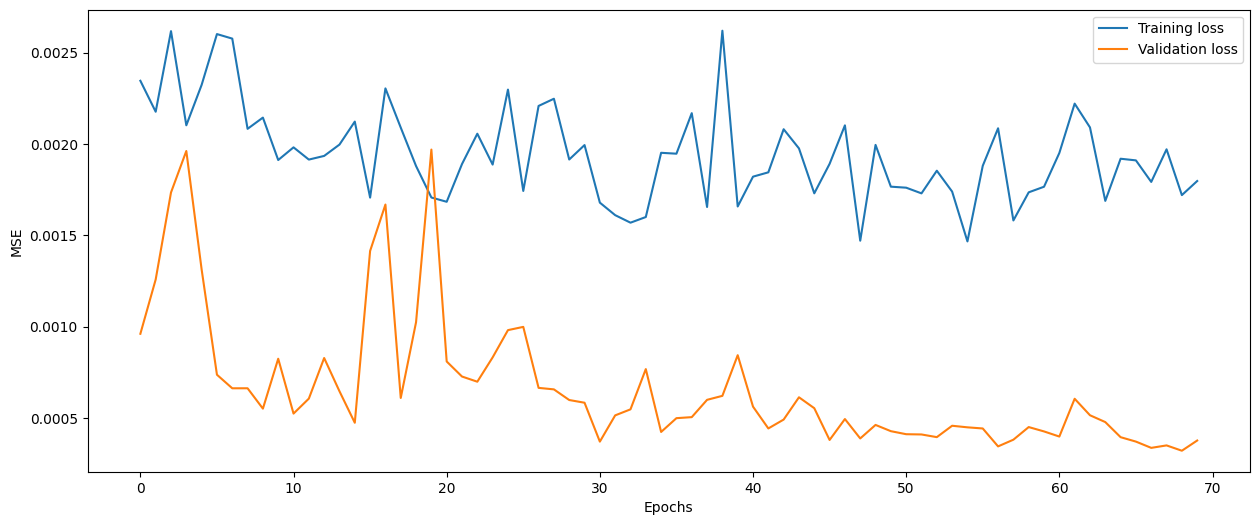

In [21]:
plt.figure(figsize=(15,6))
# plt.plot(X_train_rescaled, label='Train', color='blue')
plt.plot(np.arange(len(X_train_rescaled), len(X_train_rescaled) + len(y_test_rescaled)), y_test_rescaled, label='Test', color='orange')
plt.plot(np.arange(len(X_train_rescaled), len(X_train_rescaled) + len(y_pred_rescaled)), y_pred_rescaled, label='Prediction', color='green')
# plt.xticks(fechas)
plt.xlabel('Observación')
plt.ylabel('Precio')
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(best_model_history.history['loss'], label='Training loss')
plt.plot(best_model_history.history['val_loss'], label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [22]:
index = df.iloc[df.shape[0] - len(y_test_rescaled):, 0].index
predictions_df = pd.DataFrame(data = {'Precio de Bolsa Original': y_test_rescaled, 'Precio de Bolsa Predicho': y_pred_rescaled}, index = index)
predictions_df = predictions_df.iloc[:31 , :]
predictions_df.to_csv(os.path.join(abspath,"models", "results",f"{modelos_implementar[0]}_prediction.xlsx"))
predictions_df

,Precio de Bolsa Original,Precio de Bolsa Predicho
fecha,,
2018-03-01,146.201693,168.486782
2018-03-02,138.680593,168.486782
2018-03-03,152.410880,167.984062
2018-03-04,153.660607,164.047440
2018-03-05,174.575577,171.377222
2018-03-06,182.808030,170.477326
2018-03-07,177.889280,177.405854
2018-03-08,180.072437,168.486782
2018-03-09,177.407810,168.486782
